# Regresión Logística: Predicción de Enfermedad Coronaria

A continuación se observa un problema de clasificación binaria y se desea analizar una posible solución a partir de un modelo de regresión logística. Se busca implementar el algoritmo mencionado, inicialmente empleando la librería SciKit-Learn para luego desarrollar el mismo proceso de entrenamiento manualmente (Descenso de Gradiente Estocástico).

También se introducirán algunos conceptos para lidiar con datos desbalanceados como: matriz de confusión, curva ROC, y algunas otras métricas importantes.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.



In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
import matplotlib.mlab as mlab
%matplotlib inline

In [11]:
# cargar base heartDisease.  pd.read_csv()
heart_df=pd.read_csv("heartDisease/framingham.csv")

# dropna(axis=0 filas, inplace=True),  dropear filas con observaciones NA
heart_df.dropna(axis=0,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [12]:

# numero de observaciones 
print(f'Se tienen {len(heart_df)} datos.')

Se tienen 3749 datos.


### Análisis de Distribución de Clases

En el diagrama a continuación puede observar un claro desbalanceo de los datos, en pasos posteriores hablaremos al respecto.

<AxesSubplot:ylabel='TenYearCHD'>

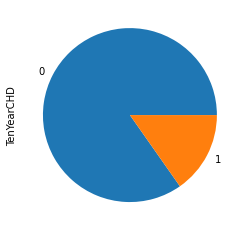

In [13]:
# value_counts().plot(kind='pie'):  hacer conteo de clases y plot tipo 'pie'
heart_df['TenYearCHD'].value_counts().plot(kind='pie')

## Descripción de Variables

Cada atributo es un factor potencial de riesgo. Existen factores demográficos, conductuales y médicos.

- Demográfico:

    - male: masculino (1) o femenino (0); (Nominal)

    - age: edad del paciente; (Continuo: aunque las edades registradas se han truncado a números enteros, el concepto de edad es continuo)

- Comportacional:

    - currentSmoker: si el paciente es o no fumador actual (nominal)

    - cigsPerDay: la cantidad de cigarrillos que la persona fumó en promedio en un día (se puede considerar continuo ya que uno puede tener cualquier cantidad de cigarrillos, incluso medio cigarrillo).

- Historia médica:

    - BPMeds: si el paciente estaba o no tomando medicación para la presión arterial (nominal)

    - prevalentStroke: si el paciente había tenido previamente un accidente cerebrovascular o no (nominal)

    - prevalentHyp: si el paciente era hipertenso (nominal)

    - diabetes: si el paciente tenía diabetes o no (nominal)

- Estado Médico actual:

    - totChol: nivel de colesterol total (continuo)

    - sysBP: presión arterial sistólica (continua)

    - diaBP: presión arterial diastólica (continua)

    - IMC: índice de masa corporal (continuo)

    - heartRate: frecuencia cardíaca (continua: en la investigación médica, variables como la frecuencia cardíaca, aunque de hecho son discretas, se consideran continuas debido a la gran cantidad de valores posibles).

    - glucose: nivel de glucosa (continuo)

- **Variable a Predecir**

    - TenYearCHD: Riesgo de padecer enfermedad coronaria 10 años en el futuro (binario: "1", significa "Sí", "0" significa "No")

In [14]:
# establecer x predictores, y observación(variable) a predecir
x = heart_df.iloc[:,:-1]
y = heart_df.iloc[:,-1]

# dividir train-set y test-set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=22)
x_train

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3841,0,52,0,0.0,0.0,0,0,0,209.0,111.0,79.0,23.63,96.0,70.0
518,1,35,1,20.0,0.0,0,0,0,231.0,122.0,72.5,22.78,72.0,93.0
1121,1,54,1,9.0,0.0,0,0,0,241.0,101.0,72.0,28.35,69.0,70.0
2335,1,50,1,20.0,0.0,0,1,0,261.0,180.0,100.0,25.90,92.0,66.0
870,1,48,0,0.0,0.0,0,0,0,247.0,131.0,79.0,22.12,78.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,0,47,1,3.0,0.0,0,0,0,155.0,122.5,77.5,21.34,65.0,78.0
3413,1,44,0,0.0,0.0,0,1,0,229.0,142.0,92.0,25.21,72.0,76.0
909,0,61,0,0.0,0.0,0,1,0,259.0,167.5,91.5,29.53,108.0,85.0
2468,1,35,0,0.0,0.0,0,0,0,275.0,132.5,79.0,34.04,75.0,80.0


In [15]:
# crear escalador MinMaxScaler() sobre los predictores X para train-set y test-set
scaler = MinMaxScaler() # Utilice un MinMaxScaler #
x_train = scaler.fit_transform(x_train) # Aplique el Escalamiento (función fit_transform) # 
x_test =  scaler.fit_transform(x_test) # Aplique el Escalamiento (función fit_transform) #

## Parte 1

A continuación, debe utilizar la función `LogisticRegression` de SciKit-Learn para obtener un primer modelo de regresión logística y calcular su precisión a partir de la función `accuracy_score`.

Obtenga resultados sobre los datos de entrenamiento y los datos de prueba. Concluya al respecto.

In [16]:
# crear modelo de regresion logistica
logreg = LogisticRegression()# Modelo de Regresión Logística #

# fit/train  ajustar el modelo para encontrar los Bi estimadores
logreg.fit(x_train, y_train) # Entrenamiento sobre los Datos #

# obtener las predicciones de clase
y_pred = logreg.predict(x_test) # Predicción de Etiquetas #

print(f'Precisión inicial: {logreg.score(x_test, y_test)}')


Precisión inicial: 0.84


### Matriz de Confusión

Como recordará, la información en este dataset no posee una distribución de clases balanceada. La matriz de confusión es una herramienta que permite analizar el comportamiento del modelo para estos datos.



Puede encontrar más información en este artículo: [Understanding Confusion Matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

## Matriz de Confusión: metricas de evaluación en clasificación


#accuracy(score)= (TP+TN)/TOT: ratio de predicciones correctas vs. totales

#recall= TP/(TP+FN): ratio de predicciones correctas de clases positivas
#recall is a good measure to determine, when high cost associated with False Negative.

#precision/sensibilidad= TP/(TP+FP): ratio de TP vs. los totales positivos, cuantos predecidos positivos son realmente positivos
#precision is a good measure to determine, when the costs of False Positive is high

#F-measure: (2*recall*precision)/(recall+precision): medición de precision(acc) y recall al mismo tiempo, penaliza los valores extremos
#F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND 
#there is an uneven class distribution (large number of Actual Negatives).

#confusion_matrix(y_test,y_pred): la matriz de confusión se calcula entre
#las observaciones del test-set yi y el vector de prediciones yi^

<AxesSubplot:>

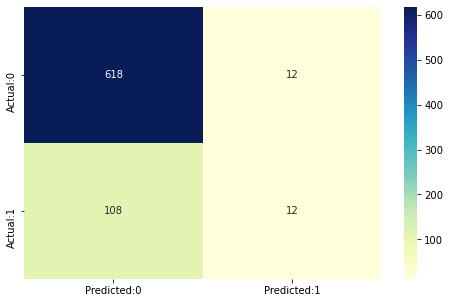

In [17]:
# crear matriz de confusión: métricas de evaluacion en clasificación 
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [18]:

    
#print(y_pred_prob_yes[4])
#print(x_test)
cm2

NameError: name 'cm2' is not defined

### Tratamiento de Datos Desbalanceados

En casos de estudio como identificación de tendencias patológicas, es común tener datos desbalanceados, o en los cuales la gravedad de cometer [errores tipo I o tipo II](https://www.simplypsychology.org/type_I_and_type_II_errors.html) son bastante diferentes. En muchos casos, se puede preferir cometer cierto tipo de error sobre el otro. Para trabajar con estos problemas, se suele preferir sacrificar algo de [precisión](https://developers.google.com/machine-learning/crash-course/classification/accuracy) del modelo, a cambio de una mejora en términos prácticos.

Este proceso se realiza a partir de la modificación del umbral a partir del cual se decide si un dato pertenece a una clase u otra. Utilice la función `binarize` para obtener valores de `0` ó `1` según las probabilidades de las predicciones realizadas utilizando la función `model.predict_proba`.

Algunas métricas utilizadas para interpretar el rendimiento del modelo son las siguientes:

- F1Score
- TP Rate / Recall / Sensitividad
- TN Rate / Especificidad

Puede encontrar más información sobre estas métricas en los artículos:
- [Accuracy, Precision, Recall or F1?](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
- [Sensitivity Vs Specificity In Data Science](https://medium.com/fintechexplained/sensitivity-vs-specificity-in-data-science-2f673039dbd1)

In [ ]:
from sklearn.preprocessing import binarize

# crear vector(array) que tiene el umbral de probabilidad para definir la pertenencia de clase
umbrales = np.linspace(0,1,20) #Vector que Contiene los Umbrales a Analizar #

# itera sobre los umbrales
for umbral in umbrales:
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test)# Utilice la función predict_proba para calcular las probabilidades de pertenecer a la clase 1 #
    
    # convierte el vector de probabilidades de pertenencia, a clases 0 y 1 
    y_pred2 = binarize(y_pred_prob_yes, threshold= umbral)# Utilice la función binarize para convertir las probabilidades a clases 0 y 1 #
    
    # crear matriz de confusión
    cm2 = confusion_matrix(y_test,y_pred2[:,1])
    
    # métricas de evaluación en función del umbral de probabilidad de pertenencia
    print(f'''->Para un umbral de {round(umbral,4)} tenemos esta matriz de confusión:
{cm2}
Con {cm2[0,0]+cm2[1,1]} predicciones correctas y {cm2[1,0]} falsos positivos.
Sensitividad/Recall: {round(cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 4)} Especificidad: {round(cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), 4)}\n''')

umbrales

Por otra parte, un criterio que facilita el visualizar este trade-off se conoce como la Curva ROC, en donde se ubican múltiples puntos para distintos valores del umbral de clasificación. Puede leer el artículo a continuación para una explicación más detallada:
- Curva ROC: [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Curva ROC para Clasificador de Enfermedad Coronaria')
plt.xlabel('Tasa de Falsos Positivos (1-Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitividad)')
plt.grid(True)

Observe la gráfica, y teniendo en cuenta los resultados concluya sobre la proporción que se puede considerar más adecuada en este contexto.

*Se quiere maximizar el area bajo la curva. para esta aplicación se quiere maximizar la tasa de TP (sensitividad/recall) a costo de precisión(acc) o tasa de FP

## Parte 2

Ahora usted debe desarrollar su propia implementación del método Descenso de Gradiente estocástico para un modelo de regresión logística. Realice el entrenamiento a partir del 80% de los datos. Al final del entrenamiento, en la lista errores se deben tener los valores de la función de error para cada iteración y así poder observar el progreso gráficamente.

In [ ]:
# crear seed para replicabilidad   
np.random.seed(22)
X_train_array = np.c_[np.ones(x_train.values.shape[0]), x_train.values]
y_train_array = y_train.values

w0 = np.random.rand(X_train_array.shape[1]) # Inicialización de w #w = w0.copy()


# Inicialización de criterio de parada (al disminuir el valor de eps, se aumenta la precisión y el tiempo de procesamiento)
eps = 1e-5
error = 100
dif = 100


def sigma(w,x):
    res_sigmoid = # Salida de la función sigmoide #
    return res_sigmoid

tasas = # Defina un vector que contenga las tasas que desea probar #



for tasa in tasas:
    # while error>eps:         # Criterio de parada 1 #
    for j in range (0, 1000):  # Criterio de parada 2 #
        # # Desarrollo de algoritmo # #
        #
        #
        #
        #
        #
        #
        # # # # # # # # # # # # # # # #
    X_test_array = np.c_[np.ones(x_test.values.shape[0]), x_test.values]
    y_test_array = y_test.values

    y_pred = np.zeros(len(x_test))

    for i in range(0,len(x_test)):
      prob = sigma(w,X_test_array[i])
      if prob>0.5:
        y_pred[i] = 1
      else:
        y_pred[i] = 0

    print(f'Precisión modelo actual: {sklearn.metrics.accuracy_score(y_test,y_pred)}')

## Matriz de Confusión

Observe y analice la matriz de confusión para su mejor modelo. Escriba claramente sus conclusiones.

In [ ]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])

plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")